In [95]:
import numpy as np # linear algebra
import pandas as pd # library for handling dataframes 

import os
base_dir = 'E:\histopathologic-cancer-detection/'
print(os.listdir(base_dir))

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image





import torch
import sys
print('Python VERSION:', sys.version)
print('pyTorch VERSION:', torch.__version__)
print('CUDA VERSION', )
from subprocess import call
#checking cuda toolkit version
! nvcc --version
print('CUDNN VERSION:', torch.backends.cudnn.version())
print('Number CUDA Devices:', torch.cuda.device_count())
print('Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

['sample_submission.csv', 'test', 'train', 'train_labels.csv']
Python VERSION: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
pyTorch VERSION: 1.8.1+cu111
CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0
CUDNN VERSION: 8005
Number CUDA Devices: 1
Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [96]:
import torch
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 2060


In [97]:
full_train_df = pd.read_csv(base_dir+"train_labels.csv")

In [98]:
print("Train Size: {}".format(len(os.listdir(base_dir+'train/'))))

Train Size: 220025


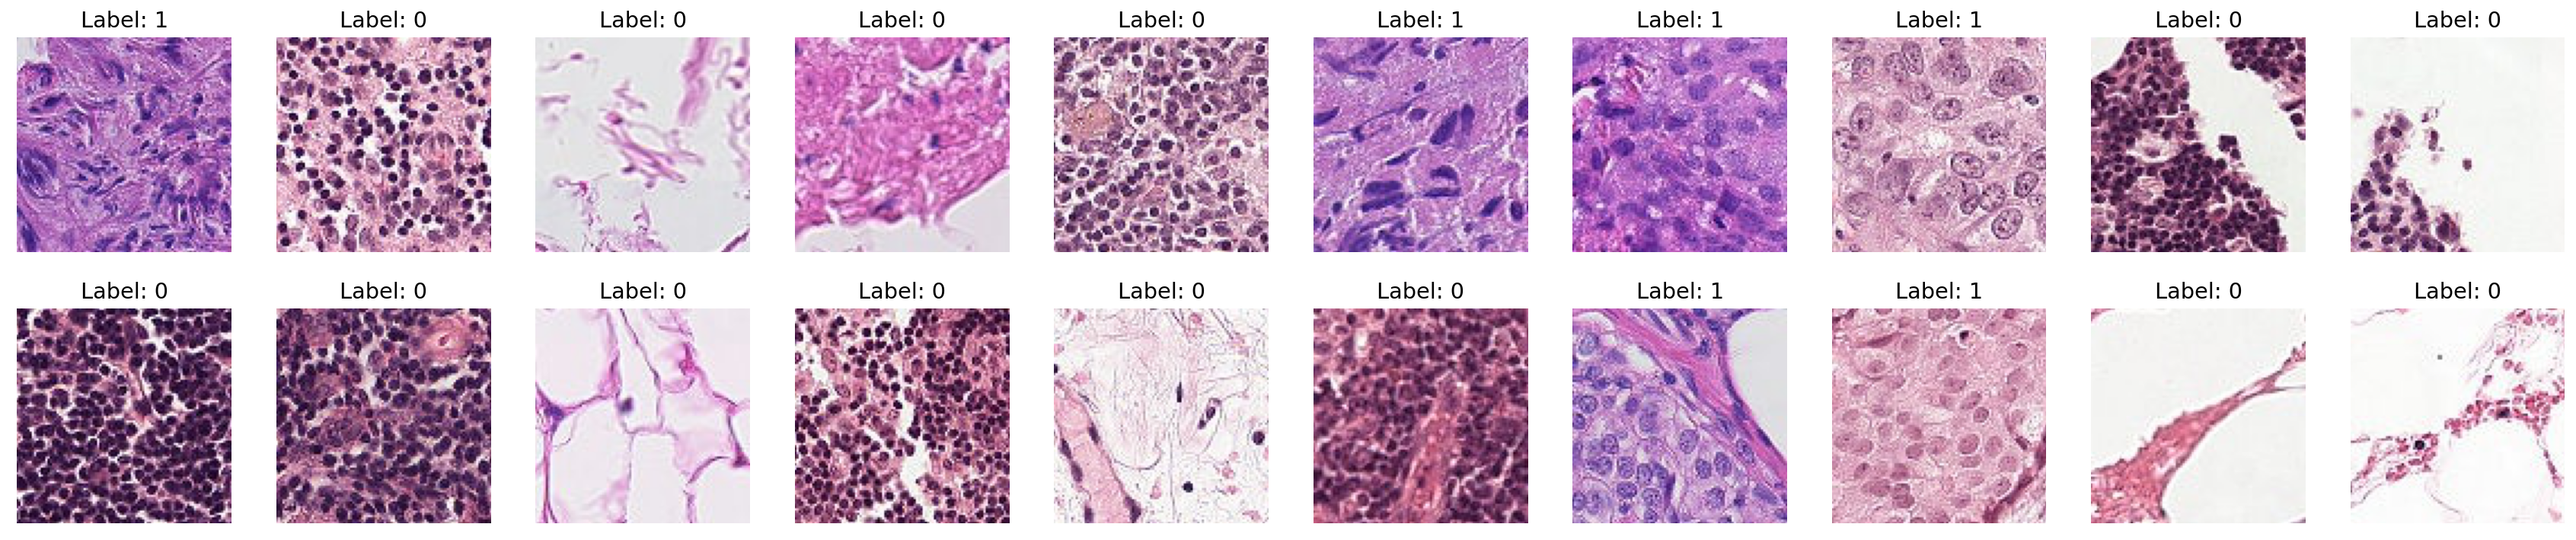

In [99]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [101]:
SAMPLE_SIZE = 40000

# Data paths
train_path = base_dir+'train/'
#test_path = base_dir+'test/'

# Use 50000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(80000, 2)

In [102]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [103]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [104]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [105]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [106]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [107]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [108]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [109]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [110]:
# number of epochs to train the model
from tqdm import tqdm

n_epochs = 20

valid_loss_min = np.Inf
max_accuracy=0
# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
auc_epoch = []


for epoch in tqdm(range(1, n_epochs+1)):

    y_final_pred=[]
    y_final_actual=[]
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print("Epoch "+str(epoch))
    # training the model #
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))
        y_final_actual=np.append(y_final_actual,y_actual)
        y_final_pred=np.append(y_final_pred,y_pred)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    print("Accuracy"+str(accuracy_score(y_final_actual,np.round(y_final_pred))))
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss
        max_accuracy=accuracy_score(y_final_actual,np.round(y_final_pred))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1


  5%|███▉                                                                           | 1/20 [20:33<6:30:38, 1233.61s/it]

Epoch: 1 | Training Loss: 0.397554 | Validation Loss: 0.329426 | Validation AUC: 0.9339
Accuracy0.85825
Validation loss decreased (inf --> 0.329426).  Saving model ...
Epoch 2


 10%|████████                                                                        | 2/20 [27:07<3:41:52, 739.58s/it]

Epoch: 2 | Training Loss: 0.331422 | Validation Loss: 0.301728 | Validation AUC: 0.9402
Accuracy0.87375
Validation loss decreased (0.329426 --> 0.301728).  Saving model ...
Epoch 3


 15%|████████████                                                                    | 3/20 [29:20<2:11:02, 462.47s/it]

Epoch: 3 | Training Loss: 0.299320 | Validation Loss: 0.281675 | Validation AUC: 0.9448
Accuracy0.88775
Validation loss decreased (0.301728 --> 0.281675).  Saving model ...
Epoch 4


 20%|████████████████                                                                | 4/20 [31:33<1:28:42, 332.64s/it]

Epoch: 4 | Training Loss: 0.282735 | Validation Loss: 0.405293 | Validation AUC: 0.9449
Accuracy0.822
Epoch 5


 25%|████████████████████                                                            | 5/20 [33:47<1:05:11, 260.79s/it]

Epoch: 5 | Training Loss: 0.262852 | Validation Loss: 0.272941 | Validation AUC: 0.9484
Accuracy0.888
Validation loss decreased (0.281675 --> 0.272941).  Saving model ...
Epoch 6


 30%|████████████████████████▌                                                         | 6/20 [36:01<50:47, 217.70s/it]

Epoch: 6 | Training Loss: 0.249064 | Validation Loss: 0.225946 | Validation AUC: 0.9517
Accuracy0.910125
Validation loss decreased (0.272941 --> 0.225946).  Saving model ...
Epoch 7


 35%|████████████████████████████▋                                                     | 7/20 [38:13<41:06, 189.76s/it]

Epoch: 7 | Training Loss: 0.235069 | Validation Loss: 0.249504 | Validation AUC: 0.9541
Accuracy0.89925
Epoch 8


 40%|████████████████████████████████▊                                                 | 8/20 [40:22<34:03, 170.33s/it]

Epoch: 8 | Training Loss: 0.225448 | Validation Loss: 0.218033 | Validation AUC: 0.9568
Accuracy0.912875
Validation loss decreased (0.225946 --> 0.218033).  Saving model ...
Epoch 9


 45%|████████████████████████████████████▉                                             | 9/20 [42:30<28:50, 157.28s/it]

Epoch: 9 | Training Loss: 0.215540 | Validation Loss: 0.227255 | Validation AUC: 0.9587
Accuracy0.91075
Epoch 10


 50%|████████████████████████████████████████▌                                        | 10/20 [44:39<24:46, 148.62s/it]

Epoch: 10 | Training Loss: 0.208891 | Validation Loss: 0.202178 | Validation AUC: 0.9605
Accuracy0.91875
Validation loss decreased (0.218033 --> 0.202178).  Saving model ...
Epoch 11


 55%|████████████████████████████████████████████▌                                    | 11/20 [46:48<21:22, 142.46s/it]

Epoch: 11 | Training Loss: 0.200862 | Validation Loss: 0.196107 | Validation AUC: 0.9620
Accuracy0.92275
Validation loss decreased (0.202178 --> 0.196107).  Saving model ...
Epoch 12


 60%|████████████████████████████████████████████████▌                                | 12/20 [48:57<18:28, 138.50s/it]

Epoch: 12 | Training Loss: 0.195384 | Validation Loss: 0.197171 | Validation AUC: 0.9631
Accuracy0.92575
Epoch 13


 65%|████████████████████████████████████████████████████▋                            | 13/20 [51:06<15:48, 135.50s/it]

Epoch: 13 | Training Loss: 0.189669 | Validation Loss: 0.185519 | Validation AUC: 0.9644
Accuracy0.93125
Validation loss decreased (0.196107 --> 0.185519).  Saving model ...
Epoch 14


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [53:19<13:28, 134.74s/it]

Epoch: 14 | Training Loss: 0.186048 | Validation Loss: 0.222520 | Validation AUC: 0.9648
Accuracy0.912125
Epoch 15


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [55:35<11:15, 135.05s/it]

Epoch: 15 | Training Loss: 0.180733 | Validation Loss: 0.186505 | Validation AUC: 0.9659
Accuracy0.926375
Epoch 16


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [57:49<08:59, 134.89s/it]

Epoch: 16 | Training Loss: 0.175944 | Validation Loss: 0.176177 | Validation AUC: 0.9669
Accuracy0.933
Validation loss decreased (0.185519 --> 0.176177).  Saving model ...
Epoch 17


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:00:05<06:45, 135.17s/it]

Epoch: 17 | Training Loss: 0.171185 | Validation Loss: 0.188549 | Validation AUC: 0.9678
Accuracy0.928625
Epoch 18


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:02:20<04:29, 134.99s/it]

Epoch: 18 | Training Loss: 0.169837 | Validation Loss: 0.193314 | Validation AUC: 0.9683
Accuracy0.926125
Epoch 19


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:04:34<02:14, 134.78s/it]

Epoch: 19 | Training Loss: 0.165864 | Validation Loss: 0.165895 | Validation AUC: 0.9691
Accuracy0.937
Validation loss decreased (0.176177 --> 0.165895).  Saving model ...
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:06:48<00:00, 200.43s/it]

Epoch: 20 | Training Loss: 0.163591 | Validation Loss: 0.157292 | Validation AUC: 0.9699
Accuracy0.939375
Validation loss decreased (0.165895 --> 0.157292).  Saving model ...


In [117]:
print("Accuracy of model = " +str(max_accuracy*100))

Accuracy of model = 93.9375


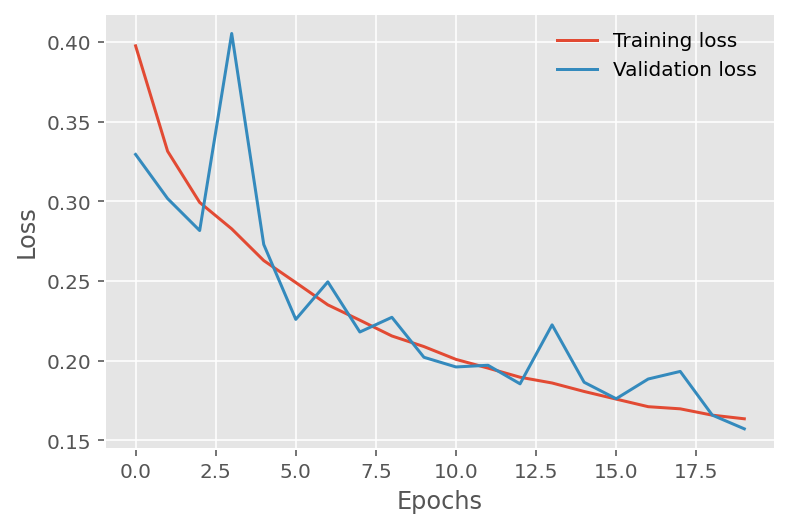

In [112]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [113]:
print(y_final_actual.shape)
print(y_final_pred.shape)


(8000,)
(8000,)


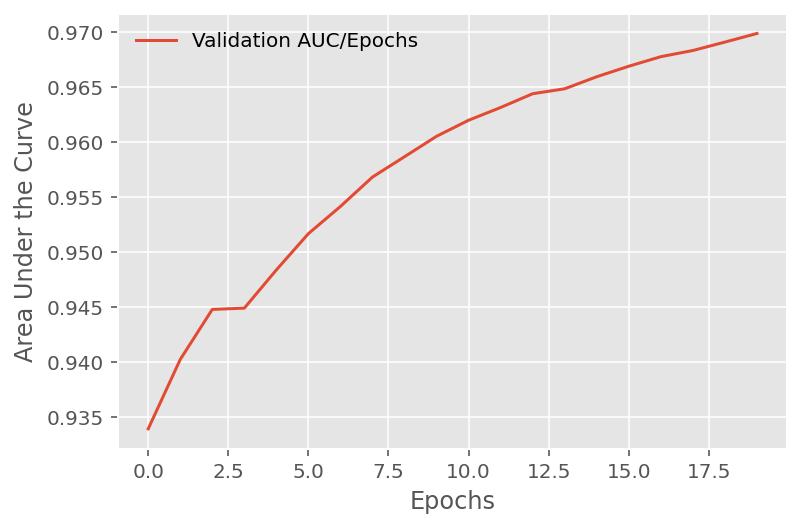

In [114]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [115]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>